In [355]:
import numpy as np
import matplotlib.pyplot as plt

In [356]:
# Policy parameterization: Softmax
# State value parameterization: Linear
# State feature vector representation: Fourier (as in HW2)

In [357]:
M = 3 # dimensionality of the fourier transform [2, 10]
# mean_policy_vector = np.ones(2*M+1)*0.05 #some non-zero vector

policy_params = np.ones((2*M+1,2))*0.01
value_params = np.ones(2*M+1)*0.01

softmax_sigma = 0.1
# policy_params = np.zeros((np.power(M+1,2),2))
# value_params = np.zeros(np.power(M+1,2))

policy_step_size = 1e-6 #2e-9
valueFunction_step_size = 1e-7
gamma = 1

In [358]:
def phi_s_cosine(given_x, given_v, cosineFlag):
    normal_x = normalized_x(given_x, cosineFlag)
    normal_v = normalized_v(given_v, cosineFlag)
    feature_phi = np.zeros(2*M+1)
#     feature_phi = np.zeros(np.power(M+1,2))
    feature_phi[0] = 1
    if cosineFlag:
        for i in range(1, M+1):
            feature_phi[i] = np.cos(i*np.pi*normal_x)
        
        for i in range(1, M+1):
            feature_phi[M+i] = np.cos(i*np.pi*normal_v)

#         for i in range(0,M+1):
#             for j in range(0,M+1):
#                 if i==0 or j==0:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
#                 else:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
    
    else:
        for i in range(1, M+1):
            feature_phi[i] = np.sin(i*np.pi*normal_x)
        
        for i in range(1, M+1):
            feature_phi[M+i] = np.sin(i*np.pi*normal_v)

#         for i in range(0,M+1):
#             for j in range(0,M+1):
#                 if i==0 or j==0:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))
#                 else:
#                     feature_phi[(M+1)*i + j] = np.cos(np.pi*(i*normal_x + j*normal_v))

    return feature_phi

In [359]:
def normalized_x(given_x, cosineFlag):
    if cosineFlag:
        return (given_x+1.2)/(0.5+1.2)
    else:
        return ((given_x+1.2)/(0.5+1.2))*2 - 1
def normalized_v(given_v, cosineFlag):
    if cosineFlag:
        return (given_v+0.07)/(0.07+0.07)
    else:
        return ((given_v+0.07)/(0.07+0.07))*2 - 1

In [360]:
def runEpisode(policy_params, gamma):
    
    episode_trace = []
    
    total_reward = 0
    x_0 = np.random.uniform(-0.6,-0.4,1)[0]
    begin_state = (x_0,0)
    
    S_t = begin_state
    S_t_plus_1 = begin_state
    for t in range(0, 1000):
        
        state_feature_vector = phi_s_cosine(S_t[0], S_t[1], True)
        state_feature_policy_param_product = np.dot(policy_params.T, state_feature_vector)
        exp_terms = np.exp(softmax_sigma * state_feature_policy_param_product)
        pi_values = exp_terms/np.sum(exp_terms)
        
#         A_t = np.random.choice([-1,1], p=list(pi_values))
        
        max_action_idx = np.argmax(pi_values)
        if max_action_idx==1:
            A_t = 1
        else:
            A_t = -1
        
#         threshold = np.dot(state_feature_vector, given_theta)
        
#         print(threshold)
        
#         if threshold<=0:
#             A_t = -1
#         else:
#             A_t = 1
        
        v_t_plus_1 = S_t[1] + 0.001*A_t - 0.0025*np.cos(3*S_t[0])
        x_t_plus_1 = S_t[0] + v_t_plus_1
        
        
        
        if x_t_plus_1 < -1.2:
            x_t_plus_1 = -1.2
            v_t_plus_1 = 0
        elif x_t_plus_1 > 0.5:
            x_t_plus_1 = 0.5
            v_t_plus_1 = 0
        
        if v_t_plus_1 < -0.07:
            v_t_plus_1 = -0.07
        elif v_t_plus_1 > 0.07:
            v_t_plus_1 = 0.07
        
        S_t_plus_1 = (x_t_plus_1, v_t_plus_1)
        
        if x_t_plus_1 == 0.5:
            print("Terminated")
            episode_trace.append((S_t, A_t, 0))
            break
        else:
            episode_trace.append((S_t, A_t, -1))
            total_reward += -1
#         print("After ",total_reward)
        

        S_t = S_t_plus_1 #Incrementing time step
    return episode_trace

In [ ]:
#With baseline
episode_length = []
curr_iter = 0
while(curr_iter<=2500):
    curr_iter += 1
    
    episode_trace = runEpisode(policy_params, gamma)
    print("\n EPISODE LENGTH: ",len(episode_trace), "CURR ITER: ", curr_iter)
    episode_length.append(len(episode_trace))
    policy_params_temp = policy_params.copy()
    for a_step in range(len(episode_trace)):
        G = 0
        for idx in range(a_step, len(episode_trace)):
            G += episode_trace[idx][2]
        
        state_t = episode_trace[a_step][0]
        state_t_feature_vector = phi_s_cosine(state_t[0], state_t[1], True)

        v_hat_s = np.dot(state_t_feature_vector, value_params)
        delta = G - v_hat_s
        
        value_params += valueFunction_step_size*delta*state_t_feature_vector
        

        state_t_feature_policy_param_product = np.dot(policy_params.T, state_t_feature_vector)
        
        
        exp_terms = np.exp(softmax_sigma*state_t_feature_policy_param_product)
        pi_values = exp_terms/np.sum(exp_terms)
        
#         print("Pi values: ",pi_values)
#         print("G: ",G,". Delta: ",delta)
        if episode_trace[a_step][1] == -1:
            policy_params[:,0] += policy_step_size*delta*(1-pi_values[0])*state_t_feature_vector
            policy_params[:,1] += policy_step_size*delta*(-pi_values[0])*state_t_feature_vector
        else:
            policy_params[:,0] += policy_step_size*delta*(-pi_values[1])*state_t_feature_vector
            policy_params[:,1] += policy_step_size*delta*(1-pi_values[1])*state_t_feature_vector
    
    max_diff = np.max(np.abs(policy_params_temp - policy_params))
    print(policy_step_size,valueFunction_step_size, " Max diff: ",max_diff)
#     if max_diff<policy_step_size*1e2 or len(episode_trace)<110:# 0.001 works with 1e-6 policy_step
#         break
    print("Mean episode length: ", np.mean(episode_length[max(0, curr_iter-100): curr_iter+1]))
    if np.mean(episode_length[max(0, curr_iter-100): curr_iter+1]) <= 125.0 or max_diff<policy_step_size*1e2:
        print("Solved.")
        break
plt.figure()
plt.plot(np.arange(len(episode_length)), episode_length)
plt.title('Mountain Car - Reinforce (Baseline)')
plt.xlabel('Number of Episodes')
plt.ylabel('Episode length')
# plt.ylim([-100, 1000])
plt.savefig('graph_mountaincar_reinforce_'+str('baseline')+'_'+str(policy_step_size)+'_'+str(valueFunction_step_size))

In [ ]:
str(episode_length)

In [373]:
actions_total = []
for i in range(len(ep2)):
    actions_total.append(sum(ep2[:i+1]))

In [374]:
len(actions_total),len(episode_length)

(348, 2501)

In [ ]:
actions_total, episode_length

In [368]:
ep1 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 380, 893, 1000, 1000, 1000, 1000, 790, 712, 1000, 1000, 1000, 1000, 1000, 1000, 742, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 796, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 852, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 970, 858, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 363, 547, 654, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 867, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 962, 824, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 958, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 899, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 953, 680, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 916, 636, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 839, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 962, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 878, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 337, 545, 632, 293, 269, 309, 256, 253, 214, 296, 516, 440, 201, 337, 348, 346, 341, 300, 210, 211, 302, 305, 273, 313, 382, 180, 206, 224, 231, 198, 206, 257, 213, 161, 218, 220, 161, 234, 206, 250, 196, 258, 156, 160, 205, 214, 266, 200, 244, 230, 205, 238, 155, 153, 199, 242, 214, 225, 247, 214, 209, 151, 204, 231, 193, 252, 224, 148, 186, 222, 208, 225, 212, 147, 206, 222, 136, 157, 163, 237, 242, 134, 134, 136, 146, 157, 142, 146, 144, 146, 140, 169, 221, 133, 135, 172, 156, 153, 151, 132, 153, 148, 185, 223, 132, 215, 129, 130, 147, 130, 150, 149, 145, 173, 132, 175, 132, 129, 178, 131, 162, 177, 138, 181, 149, 135, 177, 185, 138, 125, 133, 182, 194, 139, 139, 188, 185, 146, 186, 175, 106, 135, 152, 157, 152, 123, 180, 140, 199, 140, 163, 139, 130, 140, 116, 143, 148, 142, 211, 132, 137, 131, 144, 169, 135, 108, 113, 189, 138, 150, 153, 152, 109, 181, 139, 172, 139, 129, 195, 133, 152, 132, 138, 184, 187, 106, 108, 136, 150, 135, 164, 134, 158, 197, 106, 137, 112, 133, 110, 135, 134, 183, 133, 110, 143, 177, 169, 108, 134, 132, 109, 171, 153, 134, 108, 196, 159, 197, 129, 129, 202, 89, 133, 158, 109, 141, 217, 88, 108, 141, 136, 137, 193, 154, 189, 144, 106, 188, 182, 107, 139, 176, 134, 159, 154, 151, 174, 143, 135, 114, 132, 206, 137, 157, 136, 111, 167, 110, 170, 154, 109, 171, 108, 136, 150, 136, 183, 136, 185, 141, 135, 163, 109, 110, 148, 149, 175, 136, 198, 131, 136, 176, 132, 171, 180, 159, 136, 133, 141, 136, 125, 193, 105, 170, 108, 134, 110, 109, 137, 164, 178, 184, 85, 137, 105, 144, 105, 107, 169, 150, 135, 149, 110, 132, 130, 161, 145, 165, 152, 135, 110, 132, 162, 147, 109, 166, 118, 133, 131, 110, 173, 132, 129, 140, 161, 118, 151, 148, 134, 180, 137, 133, 130, 164, 190, 135, 159, 157, 106, 109, 135, 170, 151, 136, 149, 154, 157, 110, 136, 172, 179, 106, 136, 107, 133, 132, 204, 136, 132, 132, 108, 205, 108, 161, 104, 153, 166, 105, 159, 138, 151, 137, 110, 146, 149, 109, 134, 145, 162, 153, 136, 110, 170, 110, 132, 194, 107, 134, 186, 162, 138, 159, 137, 164, 136, 202, 178, 139, 137, 110, 139, 169, 166, 108, 168, 136, 133, 108, 195, 154, 105, 109, 177, 138, 106, 137, 121, 216, 139, 138, 106, 105, 150, 130, 110, 107, 109, 109, 127, 113, 109, 187, 109, 107, 105, 106, 146, 112, 196, 103, 174, 146, 208, 140, 106, 105, 150, 112, 104, 106, 147, 132, 148, 107, 108, 109, 109, 114, 111, 190, 105, 172, 145, 170, 135, 151, 135, 109, 131, 113, 114, 137, 108, 188, 129, 154, 156, 108, 193, 103, 103, 104, 105, 132, 184, 84, 113, 111, 115, 129, 112, 188, 103, 128, 181, 105, 152, 152, 83, 132, 142, 107, 108, 113, 135, 181, 103, 187, 108, 148, 109, 111, 112, 184, 109, 151, 132, 110, 168, 111, 175, 110, 163, 106, 133, 131, 138, 184, 110, 108, 145, 132, 166, 103, 151, 104, 108, 112, 106, 168, 131, 111, 109, 137, 111, 110, 163, 109, 108, 112, 106, 132, 143, 114, 107, 109, 200, 141, 106, 143, 105, 128, 111, 170, 106, 103, 145, 154, 110, 142, 114, 111, 165, 144, 103, 146, 130, 129, 197, 152, 110, 103, 167, 83, 110, 106, 112, 161, 130, 106, 129, 140, 146, 106, 143, 107, 112, 116, 110, 113, 143, 144, 170, 150, 106, 107, 111, 187, 105, 107, 105, 109, 128, 112, 110, 108, 139, 108, 120, 113, 175, 115, 109, 184, 105, 143, 129, 193, 107, 148, 108, 103, 103, 154, 104, 103, 152, 112, 109, 107, 137, 136, 197, 132, 104, 130, 105, 112, 136, 145, 143, 111, 148, 144, 141, 104, 141, 149, 109, 190, 105, 150, 154, 83, 134, 132, 113, 173, 168, 160, 111, 111, 105, 132, 112, 129, 108, 168, 183, 152, 134, 152, 134, 149, 150, 113, 133, 148, 132, 170, 106, 172, 134, 106, 143, 191, 135, 133, 148, 154, 108, 107, 184, 110, 108, 107, 105, 106, 147, 107, 147, 131, 194, 174, 136, 133, 132, 146, 105, 106, 165, 106, 149, 107, 113, 166, 104, 141, 107, 177, 107, 131, 169, 104, 106, 144, 112, 104, 178, 163, 104, 150, 153, 135, 167, 134, 133, 107, 131, 123, 130, 114, 179, 151, 145, 131, 168, 107, 112, 109, 114, 136, 138, 188, 110, 109, 146, 187, 108, 108, 110, 130, 150, 156, 131, 105, 111, 182, 131, 107, 112, 202, 149, 132, 180, 157, 87, 133, 132, 148, 172, 108, 108, 154, 105, 133, 143, 112, 110, 113, 158, 107, 109, 137, 163, 106, 148, 110, 173, 132, 151, 144, 106, 149, 111, 190, 156, 106, 109, 107, 169, 187, 136, 106, 134, 150, 109, 147, 181, 135, 133, 131, 106, 161, 131, 145, 112, 196, 151, 134, 106, 111, 112, 168, 104, 110, 108, 141, 202, 125, 105, 133, 146, 133, 131, 149, 146, 116, 162, 132, 171, 133, 107, 148, 106, 181, 104, 181, 103, 110, 132, 151, 148, 110, 181, 109, 104, 132, 131, 113, 105, 107, 184, 130, 113, 111, 113, 110, 106, 109, 141, 130, 146, 121, 187, 150, 163, 107, 157, 107, 153, 154, 135, 132, 165, 132, 131, 108, 112, 115, 107, 161, 129, 106, 143, 110, 184, 112, 155, 130, 109, 138, 111, 135, 114, 110, 110, 185, 183, 130, 163, 104, 113, 104, 103, 103, 112, 111, 148, 137, 176, 107, 108, 108, 104, 184, 110, 147, 162, 161, 195, 135, 168, 135, 105, 110, 133, 112, 114, 108, 110, 172, 176, 152, 112, 111, 142, 131, 191, 107, 107, 112, 130, 107, 137, 185, 103, 107, 183, 110, 112, 105, 152, 148, 108, 110, 111, 113, 105, 141, 106, 112, 106, 113, 200, 153, 110, 106, 107, 109, 112, 191, 157, 104, 103, 128, 152, 147, 110, 114, 104, 143, 171, 103, 112, 139, 174, 145, 111, 131, 167, 111, 143, 110, 153, 149, 159, 159, 154, 103, 134, 111, 104, 109, 173, 104, 105, 112, 182, 112, 110, 108, 107, 166, 130, 142, 175, 131, 131, 108, 129, 178, 107, 129, 167, 110, 149, 107, 154, 179, 134, 164, 112, 177, 111, 107, 111, 110, 150, 170, 110, 104, 110, 106, 104, 143, 165, 151, 182, 109, 110, 106, 150, 131, 171, 134, 108, 132, 176, 104, 112, 106, 122, 109, 140, 113, 129, 181, 110, 107, 112, 137, 173, 129, 103, 109, 137, 146, 142, 151, 143, 108, 176, 110, 149, 145, 170, 106, 113, 183, 106, 111, 151, 103, 112, 151, 177, 135, 112, 113, 109, 148, 130, 165, 112, 108, 129, 111, 178, 144, 104, 225, 109, 132, 135, 131, 111, 110, 141, 216, 133, 132, 145, 107, 111, 110, 111, 109, 112, 112, 140, 107, 112, 111, 148, 112, 182, 186, 157, 103, 103, 85, 109, 148, 144, 111, 141, 129, 178, 147, 103, 106, 131, 114, 114, 144, 109, 163, 145, 109, 103, 146, 106, 111, 106, 106, 109, 201, 168, 113, 146, 109, 163, 104, 104, 158, 104, 142, 110, 114, 180, 112, 165, 102, 102, 103, 146, 114, 104, 108, 111, 108, 141, 107, 110, 108, 182, 173, 156, 104, 110, 106, 107, 162, 112, 149, 129, 149, 142, 130, 106, 128, 139, 105, 114, 130, 145, 108, 111, 113, 111, 128, 224, 131, 143, 109, 108, 146, 114, 148, 110, 114, 107, 135, 192, 113, 201, 152, 105, 109, 105, 145, 104, 112, 107, 148, 131, 206, 112, 103, 105, 103, 104, 103, 115, 114, 112, 109, 148, 106, 109, 110, 144, 105, 109, 105, 107, 165, 110, 111, 125, 173, 157, 151, 105, 103, 175, 103, 155, 145, 131, 105, 108, 106, 103, 108, 140, 136, 108, 106, 166, 142, 112, 112, 105, 109, 137, 106, 112, 105, 110, 105, 111, 185, 139, 149, 104, 148, 107, 173, 103, 178, 184, 131, 170, 103, 108, 131, 103, 173, 149, 87, 103, 108, 107, 112, 107, 112, 111, 191, 106, 147, 113, 114, 115]
ep2 = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 613, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 861, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 593, 901, 291, 294, 390, 215, 394, 230, 333, 165, 260, 219, 199, 250, 300, 157, 198, 157, 200, 186, 156, 214, 221, 156, 185, 170, 153, 178, 180, 146, 149, 193, 131, 144, 208, 132, 143, 139, 140, 141, 142, 139, 130, 128, 133, 143, 140, 138, 133, 138, 137, 143, 129, 135, 136, 136, 132, 135, 141, 135, 133, 141, 137, 138, 145, 109, 106, 151, 137, 108, 138, 145, 108, 105, 136, 107, 109, 110, 136, 111, 110, 145, 107, 105, 141, 107, 166, 106, 104, 109, 105, 106, 110, 87, 108, 154, 111, 89, 107, 128, 104, 135, 114, 104, 111, 103, 109, 108, 108, 144, 107, 94, 105, 107, 103, 109, 104, 159, 104, 104, 133, 111, 111, 107, 109, 107, 104, 106, 105]
# print(str(ep2))

Text(0, 0.5, 'Total Episodes')

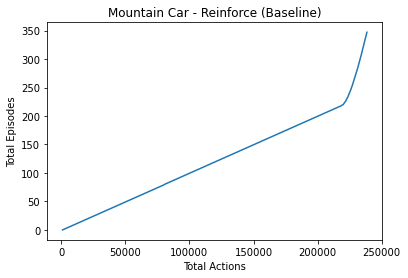

In [375]:
plt.figure()
plt.plot(actions_total, np.arange(len(ep2)))
plt.title('Mountain Car - Reinforce (Baseline)')
plt.xlabel('Total Actions')
plt.ylabel('Total Episodes')

Text(0, 0.5, 'Episode length')

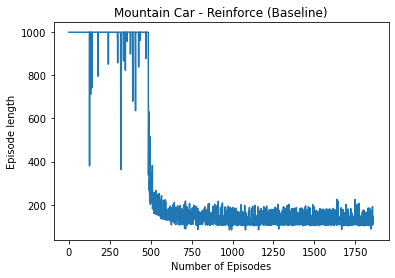

In [377]:
plt.figure()
plt.plot(np.arange(len(ep1)), ep1)
plt.title('Mountain Car - Reinforce (Baseline)')
plt.xlabel('Number of Episodes')
plt.ylabel('Episode length')